In [12]:
from crear_dataset import *
from funcions_net import *
import numpy as np
import matplotlib.pyplot as plt
import pyreadstat
import pandas as pd
from preprocessing import *
from sklearn.model_selection import train_test_split
from func_sel import *
from funcions_net import *


In [13]:

df_orig, meta = pyreadstat.read_sav("CEJFEAjut2015Updated.sav")

df_variables = pd.read_csv("variables.csv", sep=';')

dict = create_dict(meta)

df_inicial = dataset_inicial(df_orig, dict)

df_inicial['temps_fins_reincidencia1a'] = df_inicial['temps_fins_reincidencia1a'].apply(lambda x: 1095 if x > 1095 else x)





Creant dataset inicial
Creant dataset origen
(72, 15)
Creant dataset origen
(72, 37)
Delictes comesos
(72, 15)
Dataset final
(72, 15)
Dataset final
(72, 53)


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actual['Gitanos'] = np.where(df_anterior['Etnia'] ==1, 1, 0)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_actual['Magrebins'] = np.where(df_anterior['Etnia'] ==2, 1, 0)
c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\crear_dataset.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [14]:
print("Mirem quants nans tenim a cada columna")
netejat,df = neteja_na_columns(df_inicial, llindar=0.6)

df = omple_nans(df)

print("Columnes netejades")
## fem label encoding de les columnes categòriques
df = label_encoding(df)


Mirem quants nans tenim a cada columna
Columnes netejades


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\preprocessing.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_net[col].fillna(mitjana, inplace=True)


In [15]:
num_columnes = df.shape[1]
print("Hem netejat les columnes i hem fet label encoding")
print("Tenim ", num_columnes, " columnes")

Hem netejat les columnes i hem fet label encoding
Tenim  53  columnes


In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='temps_fins_reincidencia1a'), df['temps_fins_reincidencia1a'], test_size=0.2,random_state=42)


In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_train = pd.DataFrame(X_train, columns=df.drop(columns='temps_fins_reincidencia1a').columns)

In [18]:
X_train_filtrat, coef_significatius = filter_significant_features(X_train,y_train, df, llindar=0.001,alpha=0.01, print_results=True)

Hem fet el model Lasso
Hem trobat  8  coeficients nuls
Hem trobat  44  coeficients no nuls
Els coeficients no nuls ordenats per valor absolut són:
RAVEN_PD                     732.583436
Total_Del                    463.706208
RAVEN02                     -384.845573
EdatAD                       370.956229
Pri_Ing                     -274.903941
RAVEN05                     -270.779430
Nord_America                 262.540729
Robatori                    -218.227467
Robatori amb violència      -218.210547
Lesions                     -203.960770
RAVEN04                     -202.946473
Magrebins                    198.585843
Quebrantament de condemna   -189.943848
Homicidi                    -188.708866
Miscel·lània                -173.036925
Magreb                      -161.673810
RAVEN03                     -141.367950
Caucasics                   -129.292143
Administració de justícia   -124.537539
Nom_Ing                     -117.888623
dtype: float64


c:\Users\jjf20\OneDrive\Documents\Universitat\TFG\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.887e+05, tolerance: 4.958e+02
  model = cd_fast.enet_coordinate_descent(


In [19]:
## ensenyem els coef mes grans

maxims = np.sort(abs(coef_significatius))[::-1]

# Printem els índexs dels coeficients més grans
index_maxims = np.argsort(abs(coef_significatius))[::-1]
print(index_maxims[10:20])

Drogues                         11
Robatori amb violència          16
Robatori                        39
Pares_No_Catalans_Un_Espanya    35
Pares_No_Catalans_Espanya       42
Pare_Catala_Fora_Espanya        23
Pares_Catalans                  10
Nord_America                    19
Centre_Sud_America              40
Resta_Africa                     7
dtype: int64


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## fem grid search per trobar els millors hiperparàmetres

param_grid = {
    'n_estimators': [100,250,500],
    'max_depth': [30,40,50],
}

rf = RandomForestRegressor()

grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=10, 
    scoring='neg_mean_squared_error', 
    return_train_score=True
)

# Realitzem el Grid Search
grid_search.fit(X_train_filtrat, y_train)

# Resultats
print("Millor paràmetre:", grid_search.best_params_)
print("Millor precisió:", -grid_search.best_score_)  # Negatiu perquè s'ha usat neg_mean_squared_error

# Mostrem la mitjana dels resultats de test
print("Mitjana dels resultats de test per cada combinació:")
print(np.mean(grid_search.cv_results_['mean_test_score'] * -1))  # Multipliquem per -1 per obtenir el MSE positiu

best_model = grid_search.best_estimator_


Millor paràmetre: {'max_depth': 50, 'n_estimators': 100}
Millor precisió: 98234.77841366666
Mitjana dels resultats de test per cada combinació:
100752.52225627407


In [21]:
# Obtenim la importància de cada característica
coef_importants = best_model.feature_importances_

# Obtenim els noms de les característiques (suposant que tenim un DataFrame 'df')
feature_names = X_train_filtrat.columns  

# Ordenem les característiques segons la seva importància (de major a menor)
indices_ordenats = coef_importants.argsort()[::-1][0:25]

# Mostrem els noms de les 20 característiques més importants amb la seva importància
print("Les 20 característiques més importants són:")
for i in indices_ordenats:
    print(f"{feature_names[i]}: {coef_importants[i]:.4f}")



Les 20 característiques més importants són:
EdatAD: 0.1439
Mesos_Internament: 0.1424
Total_Del: 0.1383
Nom_Exp: 0.1168
RAVEN05: 0.0655
RAVEN_PD: 0.0466
RAVEN04: 0.0455
Delictes molt violents: 0.0399
RAVEN03: 0.0250
Niv_Esc: 0.0219
Pare_Catala_Fora_Espanya: 0.0193
Seguretat de l'Estat: 0.0188
Robatori amb violència: 0.0164
Lesions: 0.0161
Delictes patrimonials: 0.0137
Pri_Ing: 0.0130
Pri_Exp: 0.0122
Nord_America: 0.0104
Robatori: 0.0089
Administració de justícia: 0.0082
Subsaharians: 0.0081
RAVEN02: 0.0066
RAVEN_IQ: 0.0064
Llatins: 0.0058
Resta_Africa: 0.0056



--- AVALUACIÓ FINAL EN TEST ---
MSE (Test): 17305.1201


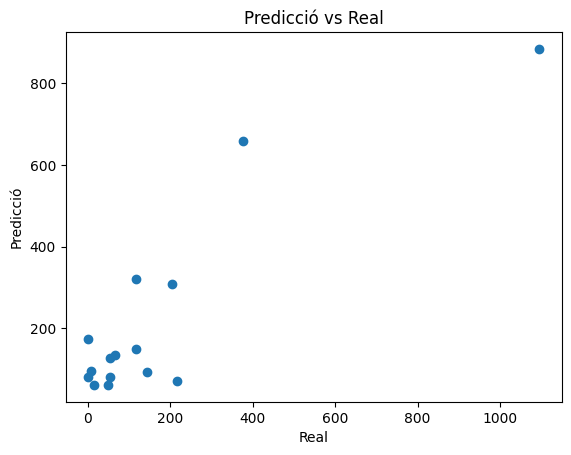

In [22]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_test = scaler.transform(X_test)
X_test_filtrat = pd.DataFrame(X_test, columns=df.drop(columns='temps_fins_reincidencia1a').columns)[coef_significatius.index]


y_test_pred = best_model.predict(X_test_filtrat)

# Calculem la mètrica MSE i R²
test_mse = mean_squared_error(y_test, y_test_pred)

print("\n--- AVALUACIÓ FINAL EN TEST ---")
print(f"MSE (Test): {test_mse:.4f}")


## plot de les prediccions
plt.scatter(y_test, y_test_pred)
plt.xlabel('Real')
plt.ylabel('Predicció')
plt.title('Predicció vs Real')
plt.show()